In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys
# Needed for the model class to work inside a Notebook.
os.environ["COBAYA_NOMPI"] = "True"
# Add everything to our paths.
repo = "/global/cscratch1/sd/mwhite/AnalyzeLAE/Cobaya/"
for codedir in ["lss_likelihood"]:
    sys.path.append(repo+codedir)

In [3]:
# GetDist is resetting the matplotlib backend to 'agg',
# which screws up inline plots.  To get around this we
# need to save the backend here and then reset it.
saved_backend = plt.rcParams["backend"]

In [4]:
from cobaya.yaml          import yaml_load_file
from cobaya.samplers.mcmc import plot_progress
from cobaya.model         import get_model
#
from getdist.mcsamples    import MCSamplesFromCobaya
from getdist.mcsamples    import loadMCSamples
import getdist.plots      as     gdplt
#
matplotlib.use(saved_backend)

### Let's take a look at some chains

In [5]:
db   = "/global/cscratch1/sd/mwhite/AnalyzeLAE/Cobaya/"
info = yaml_load_file(db + "lae_test.yaml")
print(info['params'].keys())
print(info['output'])

dict_keys(['b1', 'b2', 'bs', 'alpha0', 'alpha2', 'SN0', 'SN2'])
chains/lae_test


In [6]:
#
chains = []
clist  = []
llist  = []
legnd  = []
icol   = 0
for yaml in [\
            "lae_test.yaml",\
            ]:
    info= yaml_load_file(db + yaml)
    cc  = loadMCSamples(db + info["output"],no_cache=True,\
                        settings={'ignore_rows':0.3})
    #cc.weighted_thin(4)
    #p   = cc.getParams()
    #cc.addDerived(p.sigma8*(p.omegam/0.3)**0.5,name='S8',label='S_8')
    chains.append(cc)
    #
    col = 'C'+str(icol)
    clist.append(col)
    llist.append({'ls':'-','color':col})
    legnd.append(yaml[:-5])
    icol += 1
#
for cc in chains:
    print('\n'+cc.getName())
    #print("R-1=",cc.getGelmanRubin())
    print("Eff. samples ",cc.getEffectiveSamples())
    for k in ["b1","b2","bs","alpha0","alpha2","SN0","SN2"]:
        print( cc.getInlineLatex(k) )


lae_test
Eff. samples  336.4127536491798
b_1 = 0.78^{+0.32}_{-0.24}
b_2 = -0.5^{+4.0}_{-3.5}
b_s = 0.4\pm 4.3
\alpha_0 = -0.3\pm 4.9
\alpha_2 = 0.1\pm 5.1
SN_0 = 435^{+100}_{-100}
SN_2 = -1280\pm 9800


In [7]:
#for cc in chains:
#    print(cc.getNumSampleSummaryText())

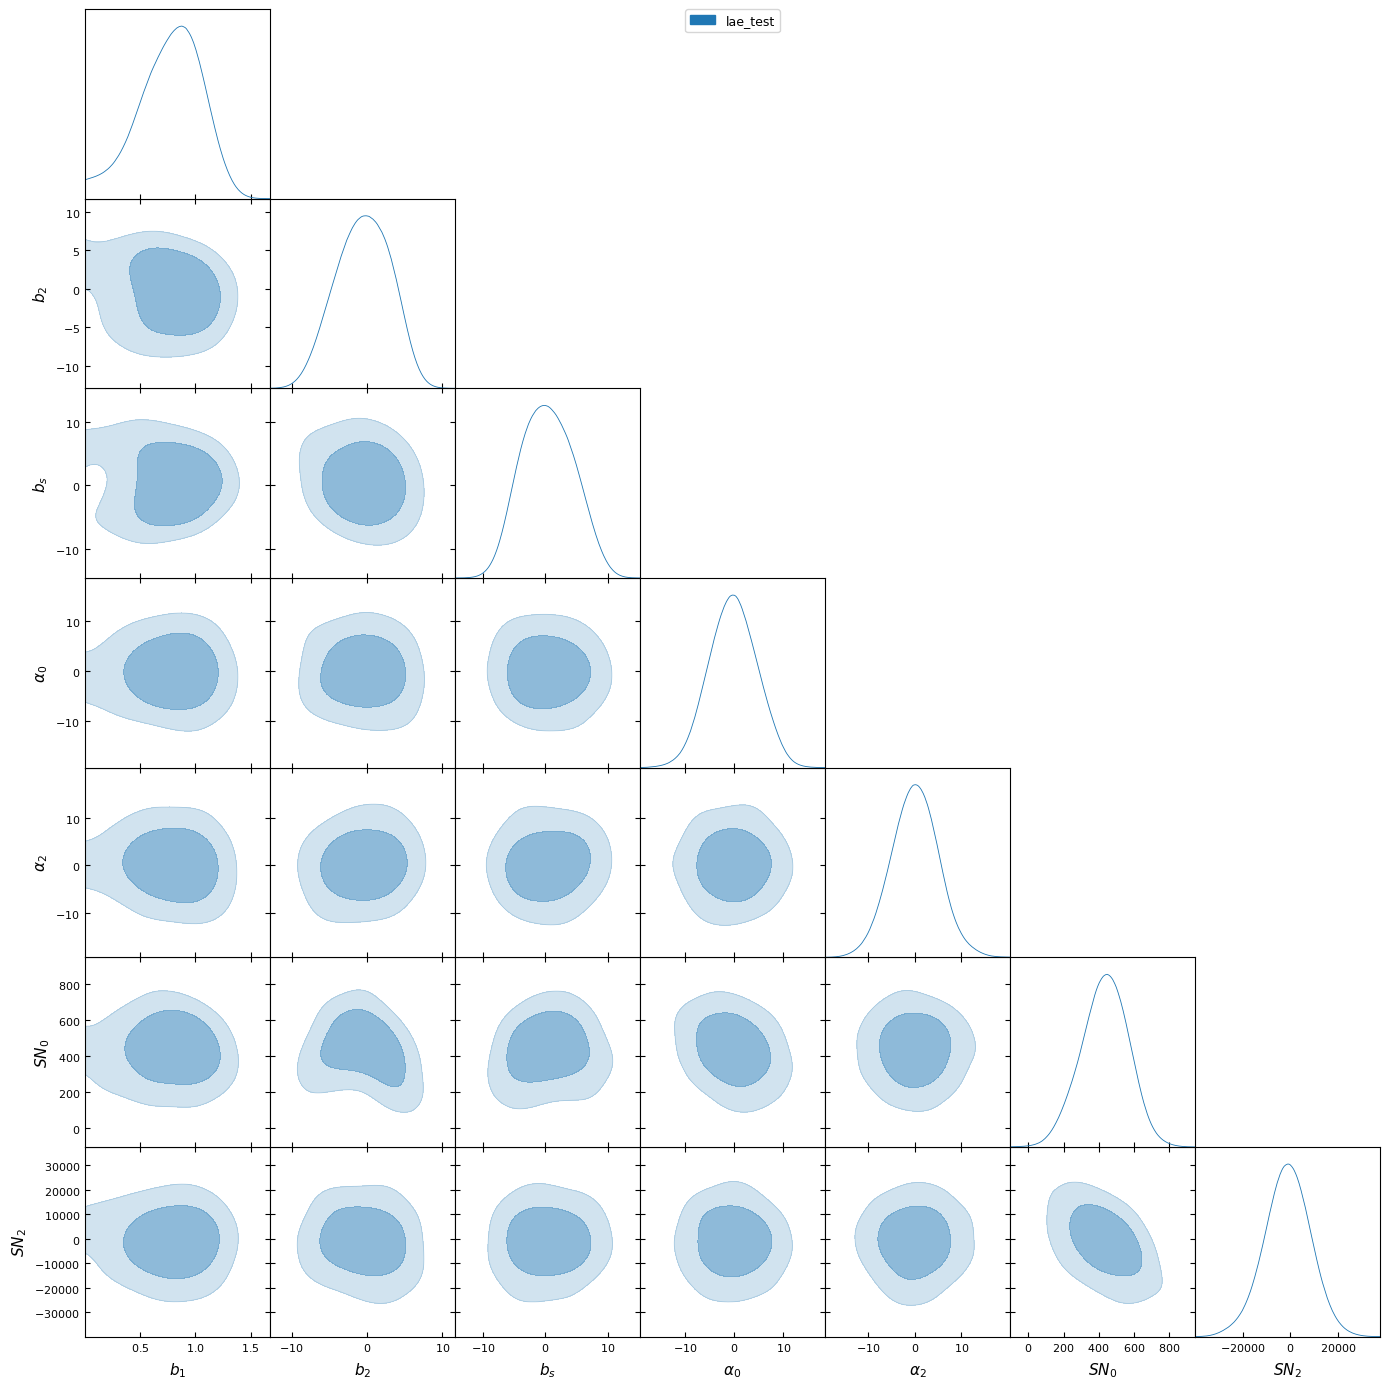

In [8]:
# Do the corner plot.
g = gdplt.get_subplot_plotter()
g.triangle_plot(chains,\
                ["b1","b2","bs","alpha0","alpha2","SN0","SN2"],\
                colors=clist,\
                line_args=llist,\
                legend_labels=legnd,\
                filled=True,alphas=[0.5]*len(chains))
#g.export('corner_plot.pdf')

<Figure size 1000x750 with 0 Axes>

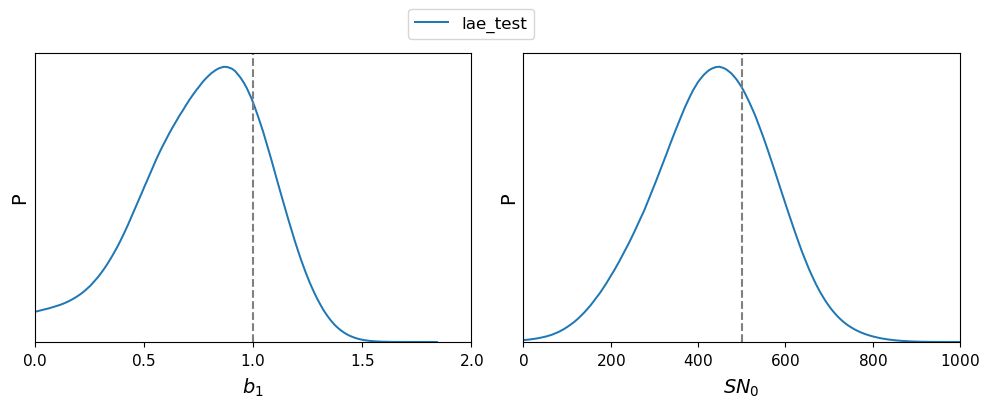

In [9]:
# Look at some 1D posteriors.
if (len(legnd)>3):
    lncol = (len(legnd)+1)//2
else:
    lncol = len(legnd)
g = gdplt.get_single_plotter(width_inch=10)
g.plots_1d(chains,['b1','SN0'],nx=2,normalized=True,\
           colors=clist,\
           legend_labels=legnd,legend_ncol=lncol,\
           constrained_layout=True,\
           xlims=[ [0.0,2.0],[0,1000.] ]);
g.subplots[0,0].axvline(1.00,color='grey',ls='--')
g.subplots[0,1].axvline(500.,color='grey',ls='--')
#
#g.export("posterior_1d.pdf")

In [10]:
# Print some limits.
for cc in chains:
    gstats  = cc.getMargeStats().parWithName('b1')
    lower68 = gstats.limits[0].lower
    lower95 = gstats.limits[1].lower
    upper68 = gstats.limits[0].upper
    upper95 = gstats.limits[1].upper
    print("\n"+cc.getName())
    print(cc.getInlineLatex('b1'))
    print("{:6.3f}<b1<{:6.3f} (68CL)".format(lower68,upper68))
    print("{:6.3f}<b1<{:6.3f} (95CL)".format(lower95,upper95))


lae_test
b_1 = 0.78^{+0.32}_{-0.24}
 0.534<b1< 1.099 (68CL)
 0.180<b1< 1.294 (95CL)


## Model class

Let's investigate things using the model class.

In [11]:
info = yaml_load_file(db + "lae_test.yaml")
model= get_model(info)
print(list(model.parameterization.sampled_params()))

[model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'stop_on_error']
['b1', 'b2', 'bs', 'alpha0', 'alpha2', 'SN0', 'SN2']


In [12]:
# Set a fiducial point.
pars = {}
pars['b1'] = 1.0
for p in ['b2','bs','alpha0','alpha2','SN0','SN2']:
    pars[p] = 0.0

In [13]:
# Force the evaluation of the likelihoods.
model.logposterior(pars)

LogPosterior(logpost=-88.78607515519228, logpriors=[-29.35300687315382], loglikes=array([-59.43306828]), derived=[], finite=False)

In [14]:
# Just so we know what likelihoods we have:
print("Have likelihoods:")
print(model.likelihood.keys())
# and what the models wanted:
#print("Model requested:")
#print(model.requested())

Have likelihoods:
dict_keys(['img_likelihood.FullShapeLikelihood'])


In [15]:
# As an example, print the first 5 entries of the observations.
# This could be anything stored in the likelihood class, e.g. C^{-1}
# or the theory or whatever.
for lik in model.likelihood.keys():
    print(lik,"\n",model.likelihood[lik].thy[100:110],"\n",model.likelihood[lik].obs[:5])

img_likelihood.FullShapeLikelihood 
 [9.42743336e-06 9.37815284e-06 9.32904672e-06 9.28011921e-06
 9.23137450e-06 9.18281682e-06 9.13445035e-06 9.08627932e-06
 9.03830792e-06 8.99054035e-06] 
 [4.80543386e-06 2.70724430e-06 1.81774862e-06 1.20714979e-06
 9.22615233e-07]


In [16]:
# Let's look at the best-fit model for the first chain.
cc   = chains[0]
pp   = cc.getParams()
ii   = np.argmin(pp.chi2)
print("Best fit model ",ii," has chi^2=",pp.chi2[ii])
#
pars = {}
for k in model.parameterization.sampled_params():
    pars[k] = cc[k][ii]
print(pars)
#
# Force the evaluation of the likelihoods.
mm = model.logposterior(pars)
print(mm)

Best fit model  4097  has chi^2= 0.00040938895
{'b1': 0.9933749, 'b2': 0.3731979, 'bs': 1.2804588, 'alpha0': -4.3034732, 'alpha2': -1.2224958, 'SN0': 656.12764, 'SN2': -16881.273}
LogPosterior(logpost=-29.960495481971897, logpriors=[-29.960290787449143], loglikes=array([-0.00020469]), derived=[], finite=False)


ell values: [ 250.  400.  550.  700.  850. 1000. 1150. 1300. 1450. 1600. 1750. 1900.]
Frac.err.:  [0.37045297 0.29297845 0.24989541 0.22153016 0.20104801 0.18536528
 0.17285966 0.16258548 0.15394943 0.14655786 0.14013799 0.13449403]


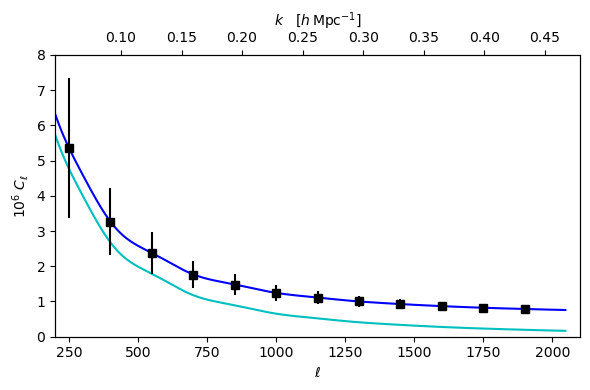

In [17]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
thy = model.likelihood['img_likelihood.FullShapeLikelihood'].thy
ell = model.likelihood['img_likelihood.FullShapeLikelihood'].ells
cls = model.likelihood['img_likelihood.FullShapeLikelihood'].cls
cov = model.likelihood['img_likelihood.FullShapeLikelihood'].cov
err = np.sqrt(np.diag(cov))
err[err>1e5]=0
print("ell values:",ell)
print("Frac.err.: ",err/cls)
#
# Now set all the higher order terms to zero to see how it looks.
pars = {}
for k in model.parameterization.sampled_params():
    pars[k] = 0.0
for k in ['b1','SN0']:
    pars[k] = cc[k][ii]
# Look at the shot-noise free theory.
pars = {}
for k in model.parameterization.sampled_params():
    pars[k] = cc[k][ii]
for k in ['SN0','SN2']:
    pars[k] = 0.0
mm = model.logposterior(pars)
lin= model.likelihood['img_likelihood.FullShapeLikelihood'].thy
#
ax.plot(np.arange(thy.size),1e6*thy,'b-')
ax.plot(np.arange(thy.size),1e6*lin,'c-')
ax.errorbar(ell,1e6*cls,yerr=1e6*err,fmt='s',color='k')
#
ax.set_xlim(200,2100)
ax.set_ylim(0.0,8.0)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$10^6\ C_\ell$')
#
chi = 4383. # Mpc/h.
kvals  = [0.1,0.15,0.2,0.25,0.3,0.35,0.40,0.45]
xticks = [k*chi for k in kvals]
xlabls = ["{:.2f}".format(k) for k in kvals]
ax2 = ax.twiny()
ax2.set_xlim(200,2100)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabls)
ax2.set_xlabel(r'$k\quad [h\,\mathrm{Mpc}^{-1}]$')
#
plt.tight_layout()

In [18]:
# This tidies up after ourselves, frees up memory, etc.
model.close()

INFO:img_likelihood.fullshapelikelihood:Average evaluation time for img_likelihood.FullShapeLikelihood: 0.0889883 s  (2 evaluations)


[img_likelihood.fullshapelikelihood] Average evaluation time for img_likelihood.FullShapeLikelihood: 0.0889883 s  (2 evaluations)


# The end